# <center> Calibrating the QICK for phase coherent readout

### <center> In this demo you will calibrate the QICK clocks to have the same phase.

Before you measure a resonance with your QICK this is the first calibration you should do. It is a calibration for the two synthesizers which belong to the QICK signal generator and the QICK readout, respectively. The two synthesizers are running at the same frequency, but there is initially a constant phase difference $\phi$ between these two synthesizers. Doing this calibration results in you finding that phase difference $\phi$. In your subsequent measurements, you can specify this initial phase difference $\phi$ to compensate for it. From then on, the signal generator can synthesize any frequency and then if you read in data (doing a digital down conversion in the process), the readout will still be phase coherent with respect to the signal generator. 

<center> The angular frequency $\omega = 2 \pi f$ .

<center> Also, $\phi = (\omega t) + \phi_0$. 

<center> So, $\phi = (2 \pi f)*t + \phi_0 $. 

If $f$ goes up linearly, the phase difference will also change linearly (it will either increase or decrease, depending on whether the readout is ahead or behind of the signal generator- this is randomly determined each time the board clocks are initialized). Once the phase hits 360 degrees it cycles back to 0 again. For a readout frequency of interest $f_i$ there is a corresponding phase difference $\phi_i$. In this demonstration we assume $f_i \approx 180$ MHz. You can plot $\phi(f)$ and evaluate $\phi(f_i)=\phi_i$.

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from qick.helpers import gauss
import time
import cmath
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc(force_init_clks=False)
# Set the loopback DAC channel to be in 1st Nyquist zone mode
soc.set_nyquist(ch=7,nqz=1); 

### Hardware Configuration

tProc channel 7   : DAC 229 CH3  <-> Readout channel 0 : ADC 224 CH0

In [3]:
class LoopbackProgram(AveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)

    def initialize(self):
        cfg=self.cfg   
        r_freq=self.sreg(cfg["res_ch"], "freq")   #Get frequency register for res_ch
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2          #add length of adc acquisition to config
        self.cfg["adc_freqs"]=[self.cfg["pulse_freq"]]*2   #add frequency of adc ddc to config
        
        self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"],idata = self.cfg["idata"])  #add a constant pulse to the pulse library

        freq=soc.freq2reg(cfg["pulse_freq"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
#         print("ADC freq = ", adcfreq(cfg["pulse_freq"]))
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq, phase=0, gain=cfg["pulse_gain"], t= 0, play=False) # pre-configure readout pulse
        self.synci(1000)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        self.pulse(ch=self.cfg["res_ch"], name="measure", play=True, outsel=1) # play readout pulse
        self.sync_all(soc.us2cycles(self.cfg["relax_delay"])) 

### First, sanity check that we can see the pulse we want to calibrate

In [4]:
config={"res_ch":7, # --Fixed
        "relax_delay":0, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        "length":250, # [Clock ticks] 
        "sigma": 30, # [Clock ticks]
        "readout_length":200, # [Clock ticks]
        "pulse_gain":10000, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 220, # [Clock ticks]
        "reps":1, 
        "soft_avgs":1,
       }
config["idata"] = gauss(mu=config["sigma"]*16*5/2,si=config["sigma"]*16,length=5*config["sigma"]*16,maxv=32000)

prog =LoopbackProgram(config)
iq0, iq1 = prog.acquire_decimated(soc, load_pulses=True,progress=False)

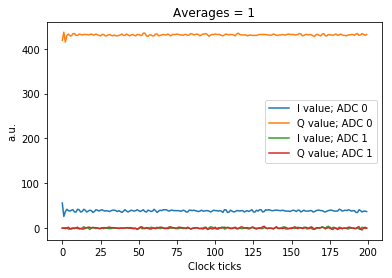

In [5]:
# Plot results.
plt.figure(1)
plt.plot(iq0[0], label="I value; ADC 0")
plt.plot(iq0[1], label="Q value; ADC 0")
plt.plot(iq1[0], label="I value; ADC 1")
plt.plot(iq1[1], label="Q value; ADC 1")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()

### Now we perform the calibration: Params 1 (spacing between points is too large) 

In [6]:
sweep_cfg={"start":100, "step":0.0005, "expts":40}

gpts=sweep_cfg["start"] + sweep_cfg["step"]*np.arange(sweep_cfg["expts"])
resultsi=[]
resultsq=[]
for g in gpts:
    time.sleep(0.1)
    config["pulse_freq"]=g
    prog =LoopbackProgram(config)
    iq0, iq1 = prog.acquire_decimated(soc, load_pulses=True,progress=False)
    di0 = np.sum(iq0[0])/config["readout_length"]
    dq0 = np.sum(iq0[1])/config["readout_length"]
    resultsi.append(di0)
    resultsq.append(dq0)
resultsi=np.array(resultsi)
resultsq=np.array(resultsq)

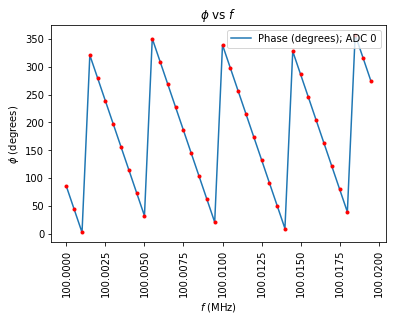

In [7]:
# Plot results.
sig = resultsi + 1j * resultsq
amp_array = np.abs(sig)
phase_array = np.angle(sig,deg=True)
for x in range(0,len(phase_array)):
    if phase_array[x] <0:
        phase_array[x] = phase_array[x] +360
plt.figure(1)
# plt.plot(gpts, resultsi,label="I value; ADC 0")
# plt.plot(gpts, resultsq,label="Q value; ADC 0")
# plt.plot(gpts, amp_array,label="Amplitude (DAC units); ADC 0")
plt.plot(gpts, phase_array, label="Phase (degrees); ADC 0")
plt.plot(gpts,phase_array, marker='.', linestyle="None",color="Red")
plt.xticks(rotation=90)
plt.title(r"$\phi$ vs $f$")
plt.ylabel(r"$\phi$ (degrees)")
plt.xlabel(r"$f$ (MHz)")
plt.legend()
plt.savefig("images/Phase_sweep.pdf", dpi=350)

### Params 2 (We try again with finer spacing and now there is enough data for us to calibrate phase)

In [8]:
sweep_cfg={"start":100, "step":0.000125, "expts":160}

gpts=sweep_cfg["start"] + sweep_cfg["step"]*np.arange(sweep_cfg["expts"])
resultsi=[]
resultsq=[]
for g in gpts:
    time.sleep(0.1)
    config["pulse_freq"]=g
    prog =LoopbackProgram(config)
    iq0, iq1 = prog.acquire_decimated(soc, load_pulses=True,progress=False)
    di0 = np.sum(iq0[0])/config["readout_length"]
    dq0 = np.sum(iq0[1])/config["readout_length"]
    resultsi.append(di0)
    resultsq.append(dq0)
resultsi=np.array(resultsi)
resultsq=np.array(resultsq)

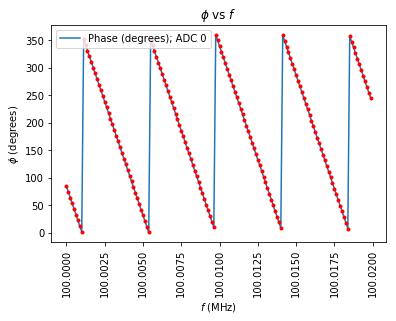

In [9]:
# Plot results.
sig = resultsi + 1j * resultsq
amp_array = np.abs(sig)
phase_array = np.angle(sig,deg=True)
for x in range(0,len(phase_array)):
    if phase_array[x] <0:
        phase_array[x] = phase_array[x] +360
plt.figure(1)
# plt.plot(gpts, resultsi,label="I value; ADC 0")
# plt.plot(gpts, resultsq,label="Q value; ADC 0")
# plt.plot(gpts, amp_array,label="Amplitude (DAC units); ADC 0")
plt.plot(gpts, phase_array, label="Phase (degrees); ADC 0")
plt.plot(gpts,phase_array, marker='.', linestyle="None",color="Red")
plt.xticks(rotation=90)
plt.title(r"$\phi$ vs $f$")
plt.ylabel(r"$\phi$ (degrees)")
plt.xlabel(r"$f$ (MHz)")
plt.legend()
plt.savefig("images/Phase_sweep.pdf", dpi=350)

### Params 3 (We zoom in on the frequency area of interest and then print out the associated phase of interest)

In [10]:
sweep_cfg={"start":100.0075, "step":0.000125, "expts":40}

gpts=sweep_cfg["start"] + sweep_cfg["step"]*np.arange(sweep_cfg["expts"])
resultsi=[]
resultsq=[]
for g in gpts:
    time.sleep(0.1)
    config["pulse_freq"]=g
    prog =LoopbackProgram(config)
    iq0, iq1 = prog.acquire_decimated(soc, load_pulses=True,progress=False)
    di0 = np.sum(iq0[0])/config["readout_length"]
    dq0 = np.sum(iq0[1])/config["readout_length"]
    resultsi.append(di0)
    resultsq.append(dq0)
resultsi=np.array(resultsi)
resultsq=np.array(resultsq)

Iteration i = 0, freq_i = 100.007500 MHz, phi_i = 185.633130 degrees
Iteration i = 1, freq_i = 100.007625 MHz, phi_i = 175.364019 degrees
Iteration i = 2, freq_i = 100.007750 MHz, phi_i = 165.018349 degrees
Iteration i = 3, freq_i = 100.007875 MHz, phi_i = 154.734810 degrees
Iteration i = 4, freq_i = 100.008000 MHz, phi_i = 144.312454 degrees
Iteration i = 5, freq_i = 100.008125 MHz, phi_i = 134.057726 degrees
Iteration i = 6, freq_i = 100.008250 MHz, phi_i = 123.783393 degrees
Iteration i = 7, freq_i = 100.008375 MHz, phi_i = 113.410937 degrees
Iteration i = 8, freq_i = 100.008500 MHz, phi_i = 103.099507 degrees
Iteration i = 9, freq_i = 100.008625 MHz, phi_i = 92.859330 degrees
Iteration i = 10, freq_i = 100.008750 MHz, phi_i = 82.454949 degrees
Iteration i = 11, freq_i = 100.008875 MHz, phi_i = 72.167962 degrees
Iteration i = 12, freq_i = 100.009000 MHz, phi_i = 61.795449 degrees
Iteration i = 13, freq_i = 100.009125 MHz, phi_i = 51.527490 degrees
Iteration i = 14, freq_i = 100.0092

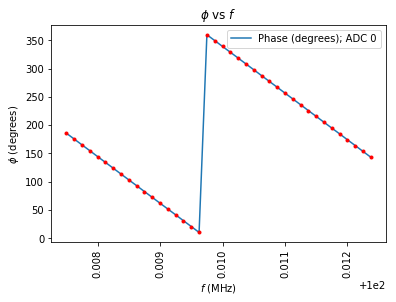

In [11]:
# Plot results.
sig = resultsi + 1j * resultsq
amp_array = np.abs(sig)
phase_array = np.angle(sig,deg=True)
for x in range(0,len(phase_array)):
    if phase_array[x] <0:
        phase_array[x] = phase_array[x] +360
    print("Iteration i = %d, freq_i = %f MHz, phi_i = %f degrees" %(x,gpts[x], phase_array[x]))
plt.figure(1)
# plt.plot(gpts, resultsi,label="I value; ADC 0")
# plt.plot(gpts, resultsq,label="Q value; ADC 0")
# plt.plot(gpts, amp_array,label="Amplitude (DAC units); ADC 0")
plt.plot(gpts, phase_array, label="Phase (degrees); ADC 0")
plt.plot(gpts,phase_array, marker='.', linestyle="None",color="Red")
plt.xticks(rotation=90)
plt.title(r"$\phi$ vs $f$")
plt.ylabel(r"$\phi$ (degrees)")
plt.xlabel(r"$f$ (MHz)")
plt.legend()
plt.savefig("images/Phase_sweep.pdf", dpi=350)

For example, if your cavity tone was generated with an IF of 420.9 MHz, you would look at the above table and see that <code> freq_i </code> = 420.9 MHz corresponds to <code> phi_i </code> = 308.7 degrees (that's specific to this board session, for your QICK it will be different). That value of <code> phi_i </code> will be used as the value of the <code> config </code> file parameter associated with the offset phase of the cavity pulse (the parameter is called <code> res_phase </code> in the demo 00_Send_recieve_pulse).